In [1]:
# basic
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

# SkLearn
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import NearestNeighbors

## Setup

## 4.1 - Training: Building Vocabulary

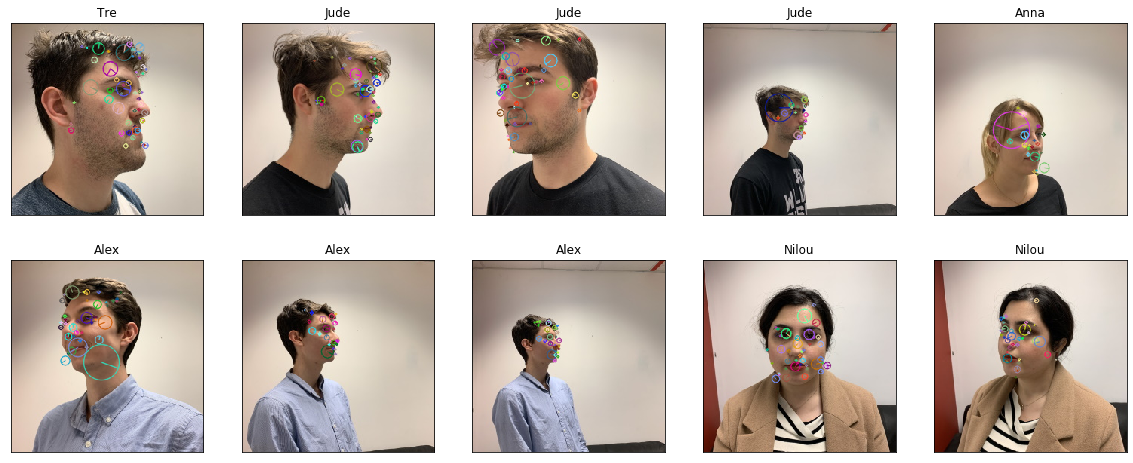

In [2]:
trainDir = "photos/preprocessed/train/"

# load bounding box
boundingBoxes = np.uint8(np.loadtxt(trainDir + "faceBoxes.txt"))

# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# holder variables for keypoints, descriptors, and labels
trainKeypoints =  []
trainDescriptors = []
labels = np.repeat(np.array([0, 1, 2, 3, 4]), 15)
names = ["Tre", "Jude", "Anna", "Alex", "Nilou"]

# randomly select 10 images to display
dispImages = np.random.randint(0, labels.shape[0], 10)

index = 0
displayedImages = 1
plt.figure(figsize=(20, 8))
for filename in os.listdir(trainDir):
    if filename.endswith(".jpg"):
        # load images and convert to RGB
        headshot = cv2.cvtColor(cv2.imread(os.path.join(trainDir, filename)), cv2.COLOR_BGR2RGB)
        headshot_display = headshot.copy()

        # detect SIFT features within the mask around the face
        mask = np.zeros(headshot.shape[:2], dtype=np.uint8)
        cv2.rectangle(mask, (boundingBoxes[index][0], boundingBoxes[index][1]), (boundingBoxes[index][2], boundingBoxes[index][3]), (255), thickness=-1)
        keypoints, descriptors = sift.detectAndCompute(headshot, mask)
        
        if index in dispImages:
            cv2.drawKeypoints(headshot, keypoints, headshot_display, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
            plt.subplot(2, 5, displayedImages), plt.imshow(headshot_display), plt.title(names[labels[index]])
            plt.xticks([]), plt.yticks([])
            displayedImages += 1
        
        # save
        trainKeypoints.append(keypoints)
        trainDescriptors.append(descriptors)
        
        # increment index
        index += 1

plt.show()

In [3]:
# cluster descriptors into K clusters using the Gaussian Mixture model
num_components=50     # TODO choose the appropriate number for K
em = GaussianMixture(n_components=num_components)
em = em.fit(np.concatenate(trainDescriptors))

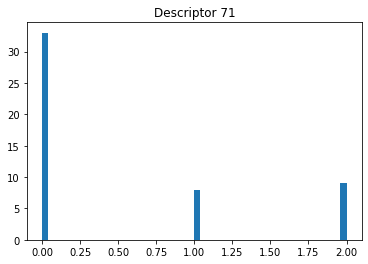

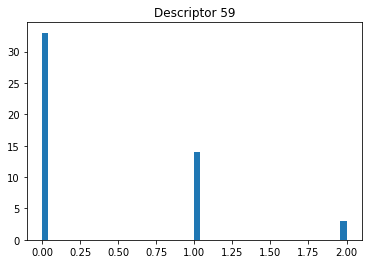

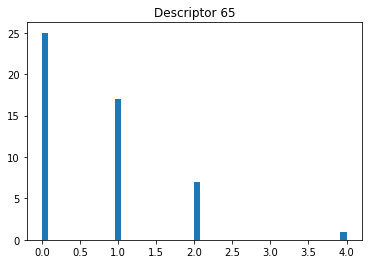

In [4]:
trainHistograms = []
for descriptor in trainDescriptors:
    predictions = em.predict(descriptor)
    histogram = np.zeros(len(em.means_))
    for i in em.predict(descriptor):
        histogram[i] += 1.0
    trainHistograms.append(histogram)
    # histogram.append(np.histogram(em.predict(descriptors), bins=num_components))

for i in np.random.randint(0, len(trainHistograms), 3):
    plt.hist(trainHistograms[i], bins=num_components)
    plt.title("Descriptor {}".format(i))
    plt.show()

0


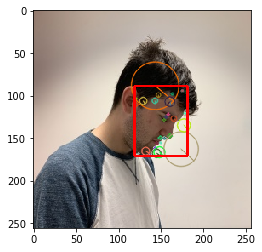

1


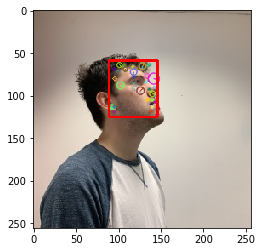

2


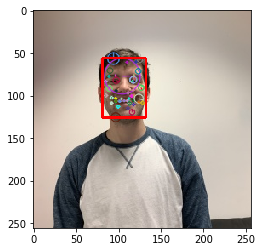

3


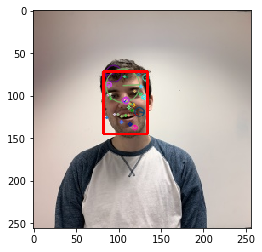

4


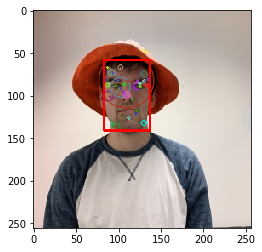

5


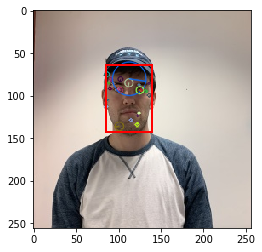

6


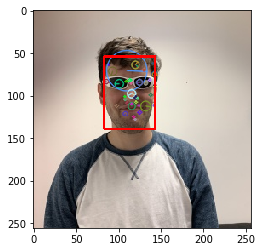

7


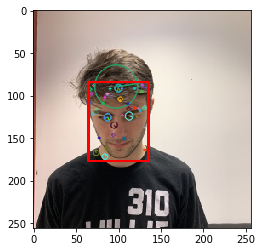

8


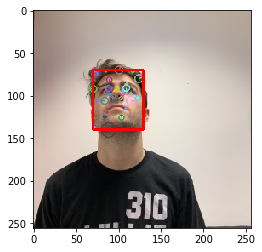

9


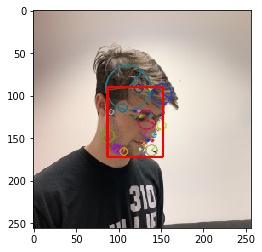

10


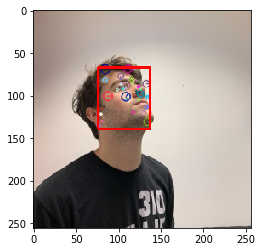

11


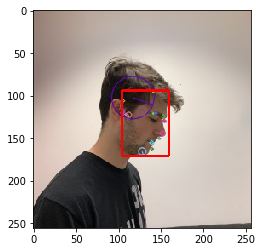

12


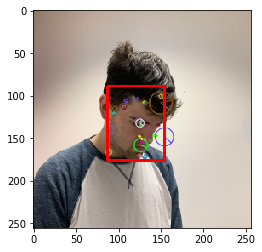

13


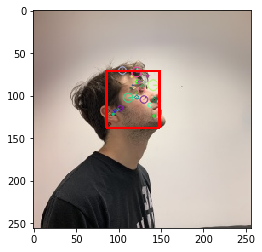

14


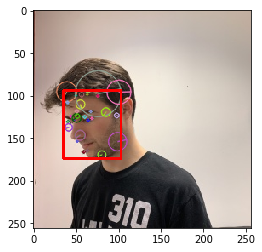

15


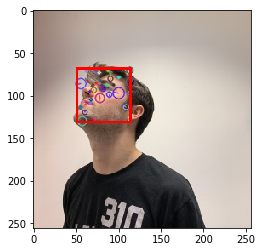

16


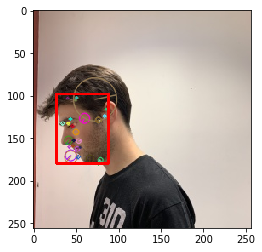

17


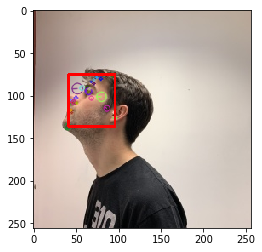

18


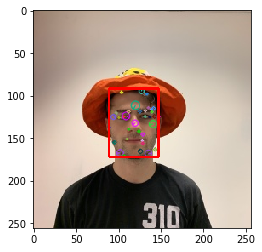

19


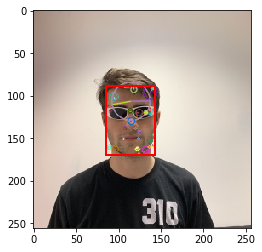

20


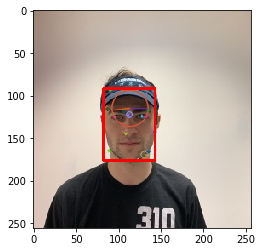

21


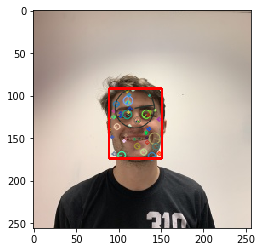

22


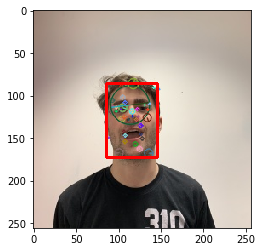

23


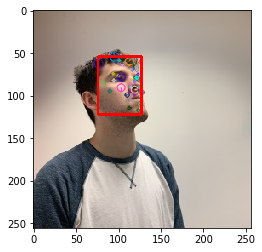

24


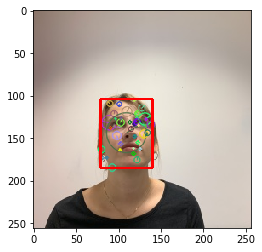

25


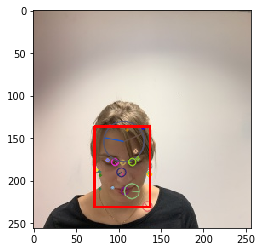

26


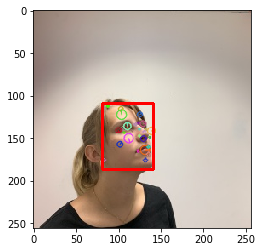

27


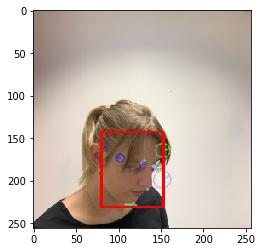

28


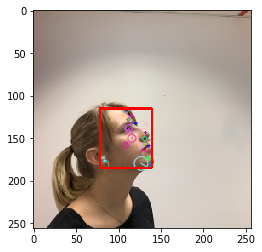

29


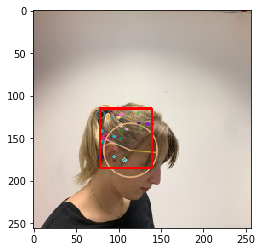

30


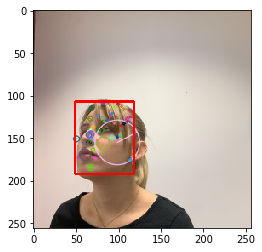

31


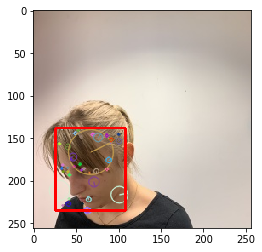

32


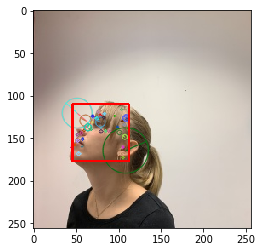

33


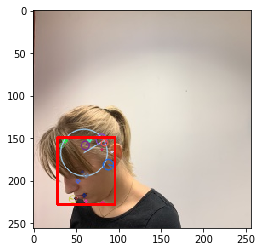

34


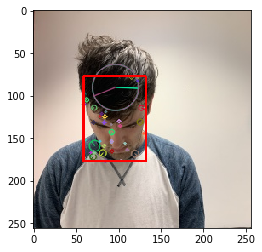

35


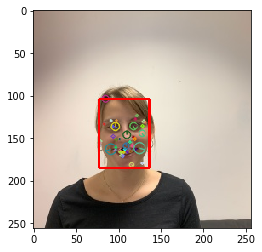

36


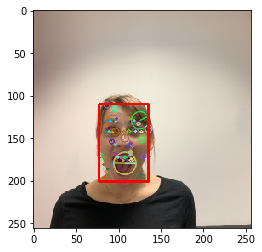

37


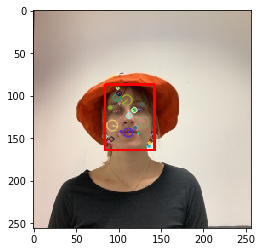

38


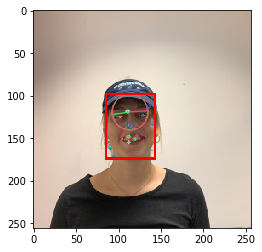

39


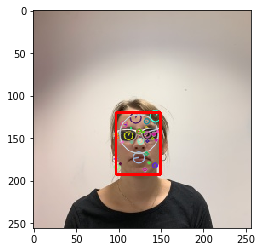

40


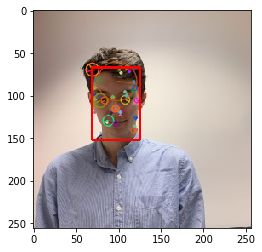

41


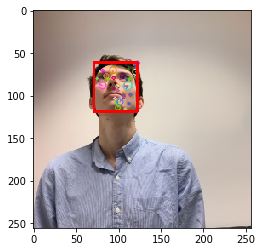

42


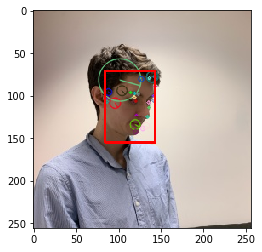

43


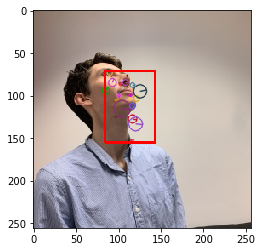

44


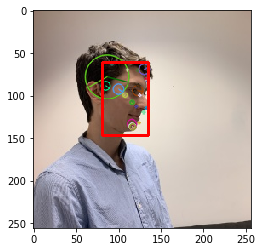

45


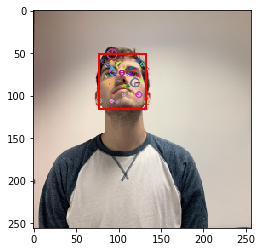

46


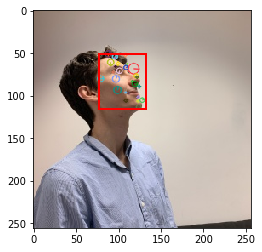

47


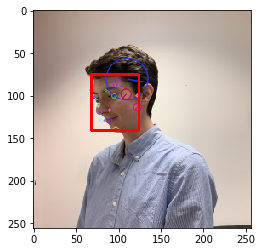

48


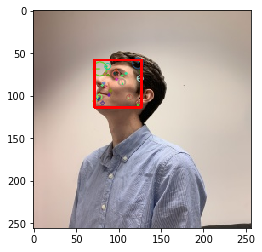

49


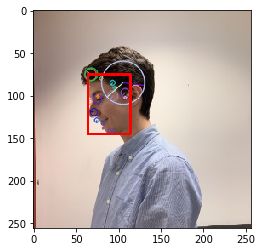

50


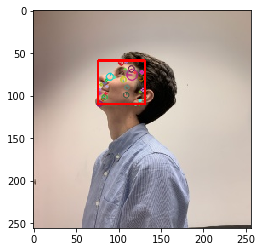

51


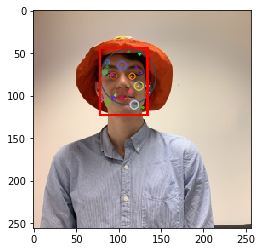

52


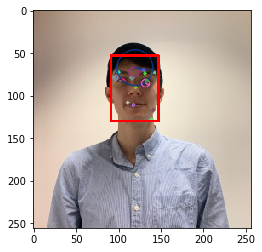

53


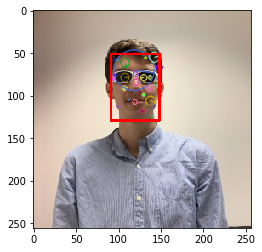

54


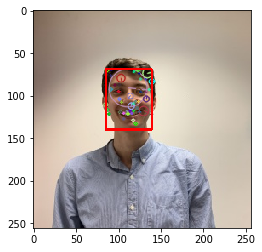

55


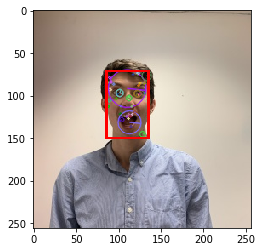

56


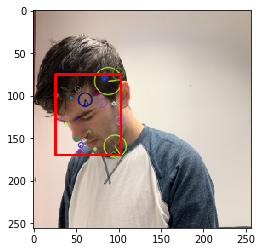

57


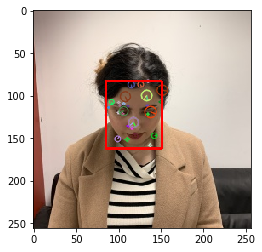

58


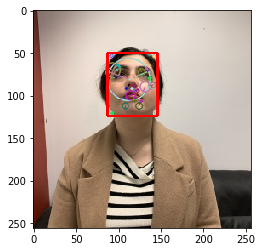

59


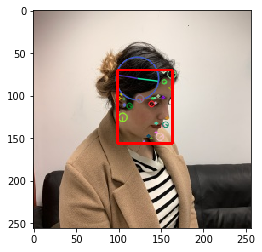

60


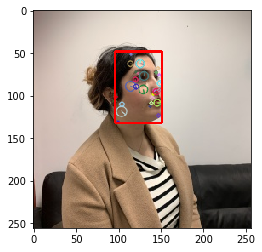

61


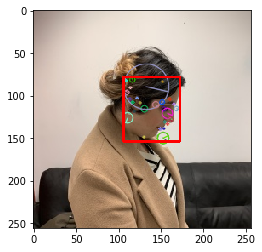

62


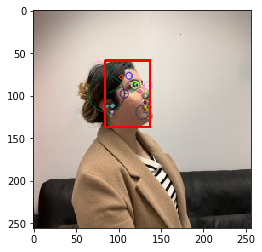

63


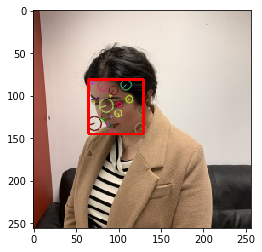

64


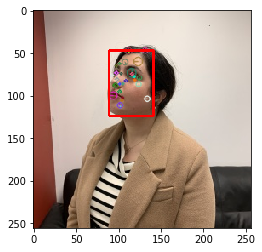

65


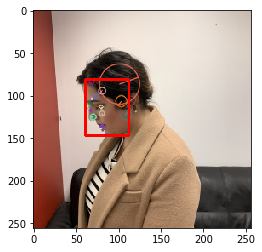

66


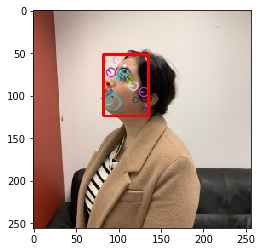

67


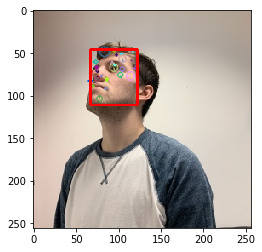

68


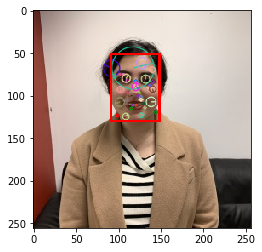

69


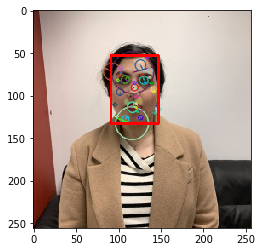

70


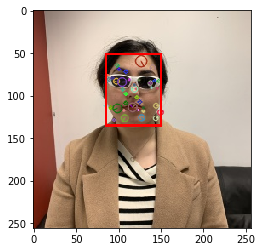

71


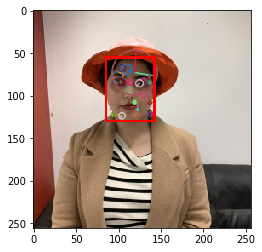

72


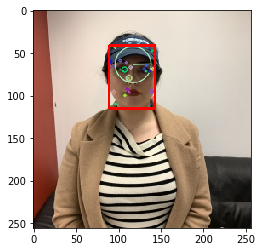

73


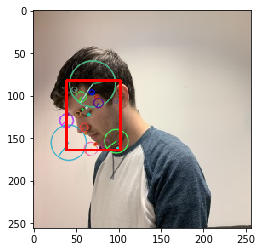

74


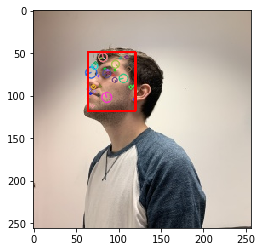

In [5]:
testDir = "photos/preprocessed/test/"

# load bounding box
boundingBoxes = np.uint8(np.loadtxt(testDir + "faceBoxes.txt"))

# create SIFT object
sift = cv2.xfeatures2d.SIFT_create()

# holder variables for keypoints, descriptors, and labels
testKeypoints =  []
testDescriptors = []

index = 0
for filename in os.listdir(testDir):
    if filename.endswith(".jpg"):
        # load images and convert to RGB
        headshot = cv2.cvtColor(cv2.imread(os.path.join(testDir, filename)), cv2.COLOR_BGR2RGB)
        headshot_display = headshot.copy()

        # detect SIFT features within the mask around the face
        mask = np.zeros(headshot.shape[:2], dtype=np.uint8)
        cv2.rectangle(mask, (boundingBoxes[index][0], boundingBoxes[index][1]), (boundingBoxes[index][2], boundingBoxes[index][3]), (255), thickness=-1)
        keypoints, descriptors = sift.detectAndCompute(headshot, mask)
        
#         cv2.drawKeypoints(headshot, keypoints, headshot_display, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#         cv2.rectangle(headshot_display, (boundingBoxes[index][0], boundingBoxes[index][1]), (boundingBoxes[index][2], boundingBoxes[index][3]), (255), thickness=2)
#         plt.imshow(headshot_display)
#         print(index)
#         plt.show()
        
        # save
        testKeypoints.append(keypoints)
        testDescriptors.append(descriptors)
        
        # increment index
        index += 1

testHistograms = []
for descriptor in testDescriptors:
    predictions = em.predict(descriptor)
    histogram = np.zeros(len(em.means_))
    for i in em.predict(descriptor):
        histogram[i] += 1.0
    testHistograms.append(histogram)
    # testHistograms.append(np.histogram(em.predict(descriptors), bins=num_components))

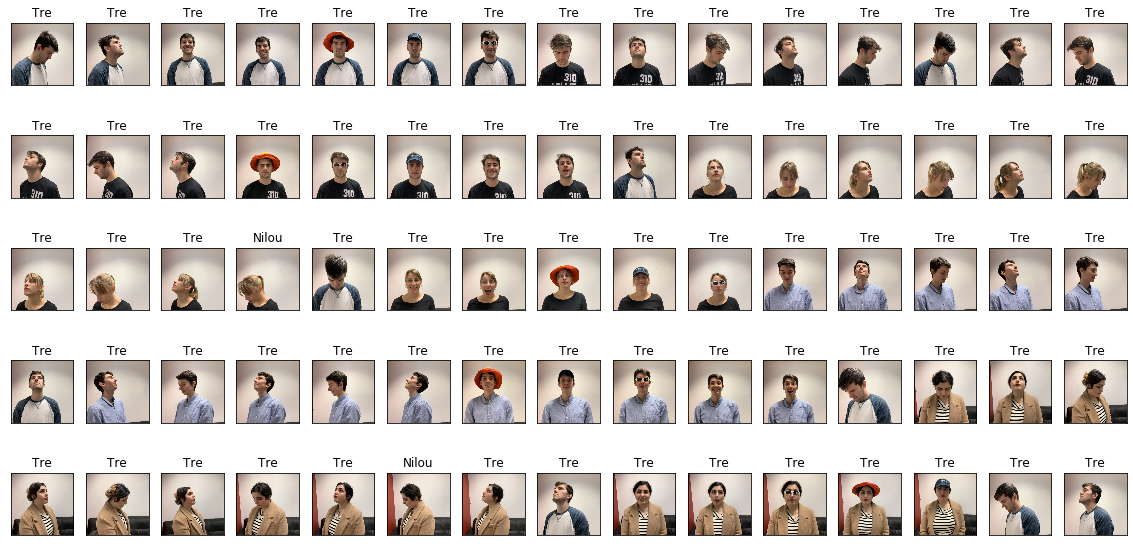

In [6]:
nearestHistograms = []        # (distances, indices)
nearestHistogramLabels = []

nn = NearestNeighbors(n_neighbors = 20)
nn.fit(trainHistograms)

for histogram in testHistograms:
    dist, result = nn.kneighbors([histogram])
    nearestHistograms.append((dist[0], result[0]))
    nearestHistogramLabels.append(labels[result[0][0]])

# display nearest histogram labels
index = 1
plt.figure(figsize=(20, 10))
for filename in os.listdir(testDir):
    if filename.endswith(".jpg"):
        plt.subplot(5, 15, index)
        plt.title(names[nearestHistogramLabels[index - 1]])
        plt.xticks([]), plt.yticks([])
        plt.imshow(cv2.cvtColor(cv2.imread(os.path.join(testDir, filename)), cv2.COLOR_BGR2RGB))
        
        # increment index
        index += 1
plt.show()

In [33]:
# dimensions: 75 pictures x number of keypoints x 2 points (x, y)
trainKeypointXY = np.asarray([np.asarray([point.pt for point in face]) for face in trainKeypoints])
testKeypointXY = np.asarray([np.asarray([point.pt for point in face]) for face in testKeypoints])

np.save('trainKeypointXY', trainKeypointXY)
np.save('testKeypointXY', testKeypointXY)